# Convolutional Neural Network for QPE (2) 
## Multi-Label Classification

In the previous example, we see tha CNN-based regression can do well in *correlation*, but the regression output is very unstable. In multiple trials, the center and spread shift randomly and hence this approach seems not suitable for forecasting.

An alternative is to train a similar CNN for multi-label or binary classification, and then use the layers before the final output as dimension reduction filters and send to a more stable regressor such as GLM or SVM.

Hence we will test classification based CNN in this example.


### [Appendix] Categorize Continuous Variables

In `numpy` there are two functions to convert continuous variables to cateogry ones: [`numpy.digitize()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html) and [`numpy.histogram()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html), but they yeld different results.

While [`numpy.histogram()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) give categories only between the specified bins, [`numpy.digitize()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html) gives extra category for values outside of the largest values in bins.

(array([ 51,  38, 155, 256], dtype=int64), array([  0,   5,  10,  30, 200]))
1     51
2     38
3    155
4    256
dtype: int64
[ 51  38 155 256]
[0, 5, 10, 30, 200]
[0, 5, 10, 30]


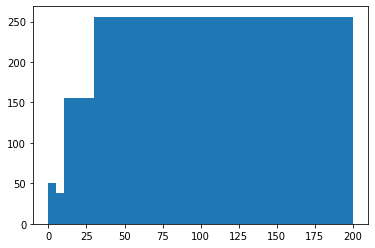

In [1]:
# This block is for testing the behavior of `numpy.histogram` and `numpy.digitize`.
# More detailed discussion can be found at: https://github.com/numpy/numpy/issues/9208
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ybins = [0, 5, 10, 30, 200]
a = np.abs(np.random.randn(500)*50)
# numpy.histogram
ha = np.histogram(a, bins=ybins)
print(ha)
plt.hist(a, bins=ybins)
# numpy.digitize
da = np.digitize(a, ybins)
dac = np.array(pd.Series(da).value_counts().sort_index())
print(pd.Series(da).value_counts().sort_index())
print(dac)
print(ybins)
print(ybins[:-1])

From the results shown above, when we use `numpy.digitize()` to categorize a continuous variable, we need to specify the number of categories in order to avoid empty bins.

In [88]:
import os, csv, logging, argparse, glob, h5py, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.utils import normalize, to_categorical

# Parameters
nLayer = 6                      # 6 10-min dbz for an hour
nY = 275                        # y-dimension of dbz data
nX = 162                        # x-dimension of dbz data
batchSize = 128                 # Batch size for training / testing
prec_bins=[0, 0.5, 10, 15, 30, 1000]
yseg_stat = [0.5, 8, 13, 29]    # 40-year statistics of hourly precipitation of trace, 90%, 95%, and 99% percentile
yseg = [0.5, 10, 15, 30]        # Actual segmentation for precipitation

#-----------------------------------------------------------------------
# Functions
#-----------------------------------------------------------------------
# Load input/output data for model
def loadIOTab(srcx, srcy, dropna=False):
    import pandas as pd
    # Read raw input and output
    #logging.info("Reading input X from: "+ srcx)
    print("Reading input X from: "+ srcx)
    xfiles = []
    for root, dirs, files in os.walk(srcx): 
        for fn in files: 
            if fn.endswith('.npy'): 
                 xfiles.append({'date':fn.replace('.npy',''), 'xuri':os.path.join(root, fn)})
    xfiles = pd.DataFrame(xfiles)
    print("... read input size: "+str(xfiles.shape))
    #logging.info("Reading output Y from: "+ srcy)
    print("Reading output Y from: "+ srcy)
    yraw = pd.read_csv(srcy, encoding='utf-8')
    yraw['date'] = yraw['date'].apply(str)
    print("... read output size: "+str(yraw.shape))
    # Create complete IO-data
    print("Pairing X-Y and splitting training/testing data.")
    iotab = pd.merge(yraw, xfiles, on='date', sort=True)
    print("... data size after merging: "+str(iotab.shape))
    # Dro NA if specified
    if dropna:
        print('Dropping records with NA')
        iotab = iotab.dropna()
        print("... data size after dropping-NAs: "+str(iotab.shape))
    # Generate weited sampling

    # Done
    return(iotab)

def generate_equal_samples(iotab, prec_bins, ylab='y', shuffle=True):
    '''Create equal sampling list: 
           repeat sample rare categories to mtach the frequency of the majority case.
    '''
    # Analysis the Precipitation
    prec_hist = np.histogram(iotab[ylab], bins=prec_bins)
    maxc = np.max(prec_hist[0])                     # Count the most frequent category
    nrep = np.round(maxc/prec_hist[0]).astype(int)  # Multiples required to reach max-count
    # Categorize precipitation by specified bins
    iotab['prec_cat'] = np.digitize(iotab[ylab], bins=prec_bins[1:-1])
    logging.debug('Sample histogram before weighted sampling:')
    logging.debug(iotab['prec_cat'].value_counts())
    # Repeat sampling by p
    for icat in range(0,len(prec_bins)-1):
        repeat_n = nrep[icat]
        tmp = iotab.loc[iotab['prec_cat']==icat,:]
        print('Append data category: '+str(icat)+' for '+ str(repeat_n) +' times with size '+str(tmp.shape))
        for j in range(int(repeat_n)-1):
            iotab = iotab.append(tmp, ignore_index=True)
    logging.debug('Sample histogram after weighted sampling:')
    logging.debug(iotab['prec_cat'].value_counts().sort_index())
    # Shuffle new dataset if specified
    if shuffle:
        iotab = iotab.sample(frac=1)#.reset_index(drop=True)
    #
    return(iotab)

def loadDBZ(flist):
    ''' Load a list a dbz files (in npy format) into one numpy array. '''
    xdata = []
    for f in flist:
        tmp = np.load(f)
        xdata.append(tmp)
    x = np.array(xdata, dtype=np.float32)
    return(x)

# Function to give report
def report_evaluation(y_true, y_pred, verbose=0):
    import sklearn.metrics as metrics
    # Calculate measures
    results = {}
    results['y_true_mean'] = y_true.mean()
    results['y_true_var'] = y_true.var()
    results['y_pred_mean'] = y_pred.mean()
    results['y_pred_var'] = y_pred.var()
    results['rmse'] = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    if y_pred.var()<=10e-8:
        results['corr'] = 0
    else:
        results['corr'] = np.corrcoef(y_true,y_pred)[0,1]
    # Print results if verbose > 0
    if verbose>0:
        if verbose>1:
            print('Mean of y_true: ' + str(results['y_true_mean']))
            print('Variance of y_true: ' + str(results['y_true_var']))
            print('Mean of y_pred: ' + str(results['y_pred_mean']))
            print('Variance of y_pred: ' + str(results['y_pred_var']))
        print('RMSE: ' + str(results['rmse']))
        print('Corr: ' + str(results['corr']))
    # Return results
    return(results)

# Create cross validation splits
def create_CV_splits(iotable, k=5, ysegs=None, ylab='y', shuffle=False):
    from sklearn.model_selection import StratifiedKFold, KFold
    # Index of each fold
    cvidx_train = []
    cvidx_test = []
    # If segmentation of y is not specified, use simple KFold
    if ysegs is None:
        kf = KFold(n_splits=k, random_state=None, shuffle=shuffle)
        for idx_train, idx_test in kf.split(iotable['xuri']):
            cvidx_train.append(idx_train)
            cvidx_test.append(idx_test)
    else:
        kf = StratifiedKFold(n_splits=k, random_state=None, shuffle=shuffle)
        for idx_train, idx_test in kf.split(iotable['xuri'], np.digitize(iotable[ylab], ysegs)):
            cvidx_train.append(idx_train)
            cvidx_test.append(idx_test)
    return((cvidx_train, cvidx_test))

def to_onehot(y, nclasses=5):
    ''' Represent the given y vector into one-hot encoding of 5 classes (0,1,2,3,4). '''
    L = len(y)                                          # Length of vector y
    yoh = np.zeros((L, nclasses), dtype=np.float32)     # The one-hot encoding, initialized with 0
    for i in range(L):
        yoh[i, 0:y[i]] = 1                              # Encode the corresponding class
        yoh[i, y[i]] = 1                                # Encode the corresponding class
    return(yoh)

def data_generator_mlc(iotab, batch_size, ylab='y'):
    ''' Data generator for batched processing. '''
    nSample = len(iotab)
    y = np.array(iotab[ylab])
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = loadDBZ(iotab['xuri'][batch_start:limit])
            Y = to_onehot(y[batch_start:limit])
            #print(X.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
    # End of generator

# CNN
def init_model_mlc(input_shape):
    """
    :Return: 
      Newly initialized model (regression).
    :param 
      int input_shape: The number of variables to use as input features.
    """
    # Input layer
    inputs = Input(shape=input_shape)
    # blovk1: CONV -> CONV -> MaxPooling
    x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='block1_conv1', data_format='channels_first')(inputs)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block1_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # block2: CONV -> CONV -> MaxPooling
    x = Conv2D(64, (3,3), activation='relu', name='block2_conv1',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64, (3,3), activation='relu', name='block2_conv2',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block2_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # block3: CONV -> CONV -> MaxPooling
    x = Conv2D(128, (3,3), activation='relu', name='block3_conv1',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(128, (3,3), activation='relu', name='block3_conv2',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block3_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # Output block: Flatten -> Dense -> Dense -> softmax output
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu', name='fc2')(x)
    x = BatchNormalization(axis=1)(x)
    # Output layer
    out = Dense(5, activation='sigmoid', name='main_output')(x)
    # Initialize model
    model = Model(inputs = inputs, outputs = out)
    # Define compile parameters
    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #sgd = SGD(lr=0.01, momentum=1e-8, decay=0.001, nesterov=True)#, clipvalue=1.)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    encoder = Model(inputs = inputs, outputs = x)
    return((model, encoder))


## Test one-hot encoding

For multi-label classification, we need to convert continuous y to categorical and one-hot encoding. Let's test it before we proceed.

In [4]:
# Read data
tmp = pd.read_csv('./data/t1hr.csv')
# Move date to index
dates = tmp['date']
t1hr = tmp.iloc[:,1:]
print(t1hr.shape)
# Max of stations
t1hr_max = t1hr.max(axis=1)

# Create y
y = pd.DataFrame({'date':dates, 't1hr':t1hr_max})
print(y.head())

(35064, 45)
         date  t1hr
0  2013010101   0.0
1  2013010102   0.0
2  2013010103   0.0
3  2013010104   0.0
4  2013010105   0.0


[0, 0.5, 10, 15, 30, 1000]


(array([19442., 13428.,   860.,   887.,   447.]),
 array([0.0e+00, 5.0e-01, 1.0e+01, 1.5e+01, 3.0e+01, 1.0e+03]),
 <a list of 5 Patch objects>)

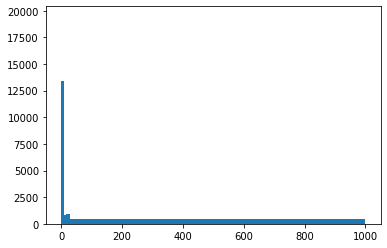

In [10]:
# Histogram
print(prec_bins)
plt.hist(y.t1hr, bins=prec_bins)

In [22]:
# Categorization
y['ycat'] = np.digitize(y.t1hr, bins=prec_bins[1:-1])
print(pd.Series(y.ycat).value_counts().sort_index())
print(np.cumsum(np.flip(pd.Series(y.ycat).value_counts().sort_index())))

0    19442
1    13428
2      860
3      887
4      447
Name: ycat, dtype: int64
4      447
3     1334
2     2194
1    15622
0    35064
Name: ycat, dtype: int64


In [18]:
tmp = np.random.randint(1,6,10)
print(tmp)
to_onehot(tmp-1, nclasses=5)

[3 4 2 2 2 2 1 1 2 5]


array([[1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [23]:
yoh = to_onehot(y.ycat, nclasses=5)
for i in range(5):
    print(np.sum(yoh[:,i]))

35064.0
15622.0
2194.0
1334.0
447.0


So far th results seems fine. We use `np.digitize()` to convert Y to categorical, while removing the boundary values in our bins.

## Data Preparation

In [35]:
logging.basicConfig(level=logging.DEBUG)
srcx = '../dbz_2016070609/'
srcy = './data/1hrmax.csv'
# Create IO table
iotab = loadIOTab(srcx, srcy, dropna=True)
# Create weighted sampling rom IOdata
newiotab = generate_equal_samples(iotab, prec_bins=prec_bins, ylab='t1hr', shuffle=True)
#
print(iotab.shape)
print(newiotab.shape)
print(iotab['prec_cat'].value_counts().sort_index())
print(newiotab['prec_cat'].value_counts().sort_index())

Reading input X from: ../dbz_2016070609/
... read input size: (92, 2)
Reading output Y from: ./data/1hrmax.csv
... read output size: (35064, 2)
Pairing X-Y and splitting training/testing data.
... data size after merging: (92, 3)
Dropping records with NA
... data size after dropping-NAs: (92, 3)
Append data category: 0 for 2 times with size (23, 4)
Append data category: 1 for 1 times with size (50, 4)
Append data category: 2 for 6 times with size (9, 4)
Append data category: 3 for 7 times with size (7, 4)
Append data category: 4 for 17 times with size (3, 4)
(92, 4)
(250, 4)
0    23
1    50
2     9
3     7
4     3
Name: prec_cat, dtype: int64
0    46
1    50
2    54
3    49
4    51
Name: prec_cat, dtype: int64


In [89]:
model = init_model_mlc((nLayer, nY, nX))
model[0].summary()
steps_train = np.ceil(newiotab.shape[0]/16)

hist = model[0].fit_generator(data_generator_mlc(newiotab, 16, ylab='prec_cat'), steps_per_epoch=steps_train, epochs=10, max_queue_size=16, verbose=0)

print(pd.DataFrame(hist.history))

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 6, 275, 162)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 273, 160)      1760      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 273, 160)      128       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 136, 80)       0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 32, 136, 80)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 134, 78)       18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 134, 78)       256

In [90]:
# Test
steps_test = np.ceil(iotab.shape[0]/16)
y_pred = model[0].predict_generator(data_generator_mlc(iotab, 16, ylab='prec_cat'), steps=steps_test, verbose=1)
yp = ((y_pred>0.5)*1.0)
print(yp - to_onehot(iotab.prec_cat))

6/6 [==============================] - 1s 86ms/step
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.

## Test Model Output

We stored another model contains the first N-1 layers of the complete model. Let's check if the partial model is trained:

In [91]:
print('The output of the (n-1)th layer of the complete model:')
print(model[0].layers[-2].get_weights()[1])
print('The output of the partial model:')
print(model[1].layers[-1].get_weights()[1])

The output of the (n-1)th layer of the complete model:
[ 0.19173884 -0.09820265  0.0383967  -0.14314505 -0.11193918 -0.00382341
 -0.13451558 -0.04491406  0.02882116 -0.018591    0.13941702  0.12168088
 -0.07752114  0.09162995 -0.02970859  0.17614457]
The output of the partial model:
[ 0.19173884 -0.09820265  0.0383967  -0.14314505 -0.11193918 -0.00382341
 -0.13451558 -0.04491406  0.02882116 -0.018591    0.13941702  0.12168088
 -0.07752114  0.09162995 -0.02970859  0.17614457]
